In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as  sns

In [22]:
feature_names_df = pd.read_csv('human_activity/features.txt', sep='\s+',
                                                            header=None, names=['column_index', 'column_name'])
feature_name = feature_names_df.iloc[:, 1].values.tolist()
feature_name[:10] # column 10개만 추출

['tBodyAcc-mean()-X',
 'tBodyAcc-mean()-Y',
 'tBodyAcc-mean()-Z',
 'tBodyAcc-std()-X',
 'tBodyAcc-std()-Y',
 'tBodyAcc-std()-Z',
 'tBodyAcc-mad()-X',
 'tBodyAcc-mad()-Y',
 'tBodyAcc-mad()-Z',
 'tBodyAcc-max()-X']

##### 중복 컬럼명 확인

In [23]:
feature_dup_df = feature_names_df.groupby('column_name').count()
print(feature_duf_df.loc[feature_duf_df['column_index']>1].count())

column_index    42
dtype: int64


- 42개의 feature가 중복됨

In [24]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                                             columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 
                                                                          'dup_cnt']].apply(lambda x: x[0]+'_'+str(x[1])
                                                                                    if x[1] > 0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [25]:
def get_human_dataset():
    feature_name_df = pd.read_csv('human_activity/features.txt', sep='\s+',
                                         header=None, names=['column_index', 'column_name'])
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    X_train = pd.read_csv('human_activity/train/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('human_activity/test/X_test.txt', sep='\s+', names=feature_name)
    
    y_train = pd.read_csv('human_activity/train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('human_activity/test/y_test.txt', sep='\s+', header=None, names=['action'])    
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB


- column 모두 float

In [27]:
y_train['action'].value_counts()

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64

##### 동작 예측 분류

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [29]:
dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(f"결정 트리 예측 정확도: {accuracy:.4f}")
print(f"기본 하이퍼 파리미터:\n", dt_clf.get_params())

결정 트리 예측 정확도: 0.8548
기본 하이퍼 파리미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


In [30]:
from sklearn.model_selection import GridSearchCV

In [31]:
# max_depth
dt_params = {'max_depth': [6, 8, 19, 12, 16, 20, 24],
                        'min_samples_split': [16]}

dt_gs = GridSearchCV(dt_clf, param_grid=dt_params, cv=5, verbose=1, scoring='accuracy')
dt_gs.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=156),
             param_grid={'max_depth': [6, 8, 19, 12, 16, 20, 24],
                         'min_samples_split': [16]},
             scoring='accuracy', verbose=1)

In [32]:
print(dt_gs.best_score_)
print(dt_gs.best_params_)

0.8548794147162603
{'max_depth': 8, 'min_samples_split': 16}


In [33]:
cv_results_df = pd.DataFrame(dt_gs.cv_results_)
cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.847662
1,8,0.854879
2,19,0.849848
3,12,0.845768
4,16,0.847127
5,20,0.848624
6,24,0.848624


In [34]:
max_depths = [6, 8, 10, 12, 16, 20, 24]
for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth, min_samples_split=16, random_state=156)
    dt_clf.fit(X_train, y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print(f'max_depth = {depth} 정확도: {accuracy:.2f}')
    

max_depth = 6 정확도: 0.86
max_depth = 8 정확도: 0.87
max_depth = 10 정확도: 0.86
max_depth = 12 정확도: 0.86
max_depth = 16 정확도: 0.86
max_depth = 20 정확도: 0.86
max_depth = 24 정확도: 0.86


In [35]:
# max_depth, min_samples_split
params = {
    'max_depth': [8, 12, 16, 20],
    'min_samples_split': [16, 24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, cv=5, scoring='accuracy', verbose=2)
grid_cv.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ..................max_depth=8, min_samples_split=16; total time=   1.4s
[CV] END ..................max_depth=8, min_samples_split=16; total time=   1.4s
[CV] END ..................max_depth=8, min_samples_split=16; total time=   1.4s
[CV] END ..................max_depth=8, min_samples_split=16; total time=   1.4s
[CV] END ..................max_depth=8, min_samples_split=16; total time=   1.4s
[CV] END ..................max_depth=8, min_samples_split=24; total time=   1.4s
[CV] END ..................max_depth=8, min_samples_split=24; total time=   1.4s
[CV] END ..................max_depth=8, min_samples_split=24; total time=   1.3s
[CV] END ..................max_depth=8, min_samples_split=24; total time=   1.4s
[CV] END ..................max_depth=8, min_samples_split=24; total time=   1.4s
[CV] END .................max_depth=12, min_samples_split=16; total time=   2.0s
[CV] END .................max_depth=12, min_sampl

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=24,
                                              min_samples_split=16,
                                              random_state=156),
             param_grid={'max_depth': [8, 12, 16, 20],
                         'min_samples_split': [16, 24]},
             scoring='accuracy', verbose=2)

In [36]:
print(f'정확도: {grid_cv.best_score_:.4f}')
print(f'최고의 파라미터: {grid_cv.best_params_}')

정확도: 0.8549
최고의 파라미터: {'max_depth': 8, 'min_samples_split': 16}


In [37]:
best_dt_clf = grid_cv.best_estimator_
pred = best_dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(f'예측 정확도: {accuracy:.4f}')

예측 정확도: 0.8717


##### Feature Importances

In [38]:
importances_values = best_dt_clf.feature_importances_
importances = pd.Series(importances_values, index=X_train.columns)
top20 = importances.sort_values(ascending=False)[:20]

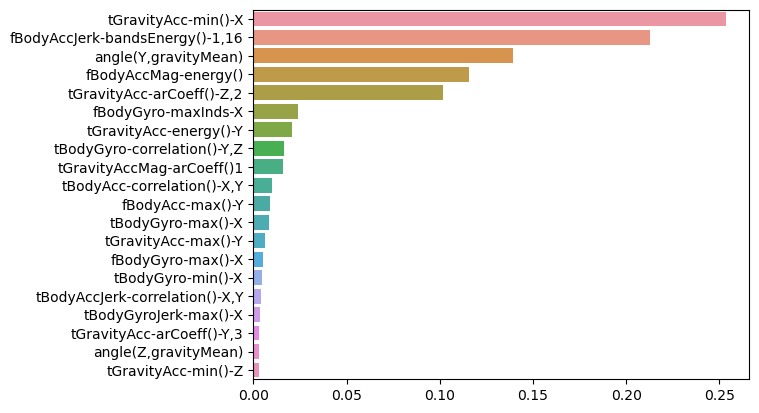

In [39]:
sns.barplot(x=top20, y=top20.index)
plt.show()

### Voting Classifier

In [40]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [41]:
cancer = load_breast_cancer()

In [42]:
data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)

In [43]:
data_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [44]:
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)

In [45]:
vo_clf = VotingClassifier(estimators=[('LR', lr_clf), ('KNN', knn_clf)], voting='soft')

In [46]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=156)

In [47]:
vo_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('LR', LogisticRegression(solver='liblinear')),
                             ('KNN', KNeighborsClassifier(n_neighbors=8))],
                 voting='soft')

In [48]:
pred = vo_clf.predict(X_test)

In [49]:
print(f'Voting 분류기 정확도: {accuracy_score(y_test, pred):.4f}')

Voting 분류기 정확도: 0.9561


In [50]:
# 개별 정확도 확인

# LogisticRegression
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
print('Logistic Regression 정확도:', accuracy_score(y_test, pred))

# KNeighborsClassifier
knn_clf.fit(X_train, y_train)
pred = knn_clf.predict(X_test)
print('KNeighborsClassifier 정확도:', accuracy_score(y_test, pred))

Logistic Regression 정확도: 0.9473684210526315
KNeighborsClassifier 정확도: 0.9385964912280702


C:\Users\cndud\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


### Bagging (RandomForestClassifier)

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
X_train, X_test, y_train, y_test = get_human_dataset()

In [53]:
rf_clf = RandomForestClassifier(random_state=0, max_depth=8)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy_score(y_test, pred)

C:\Users\cndud\AppData\Local\Temp\ipykernel_31984\1416478491.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(X_train, y_train)


0.9195792331184255

In [54]:
params = {
    'max_depth': [8, 16, 24],
    'min_samples_leaf': [1, 6, 12],
    'min_samples_split': [2, 8, 16]
}

grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

C:\Users\cndud\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=2,
             estimator=RandomForestClassifier(max_depth=8, random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': [8, 16, 24],
                         'min_samples_leaf': [1, 6, 12],
                         'min_samples_split': [2, 8, 16]})

In [55]:
print(f'최적 하이퍼 파라미터: {grid_cv.best_params_}')
print(f'최고 예측 정확도: {grid_cv.best_score_}')

최적 하이퍼 파라미터: {'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 2}
최고 예측 정확도: 0.9164853101196953


In [56]:
best_rf = grid_cv.best_estimator_

In [57]:
best_rf.fit(X_train, y_train)
pred = best_rf.predict(X_test)
accuracy_score(y_test, pred)

C:\Users\cndud\AppData\Local\Temp\ipykernel_31984\1733665405.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  best_rf.fit(X_train, y_train)


0.9260264675941635

In [58]:
# Feature Importances
fi = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)[:20]

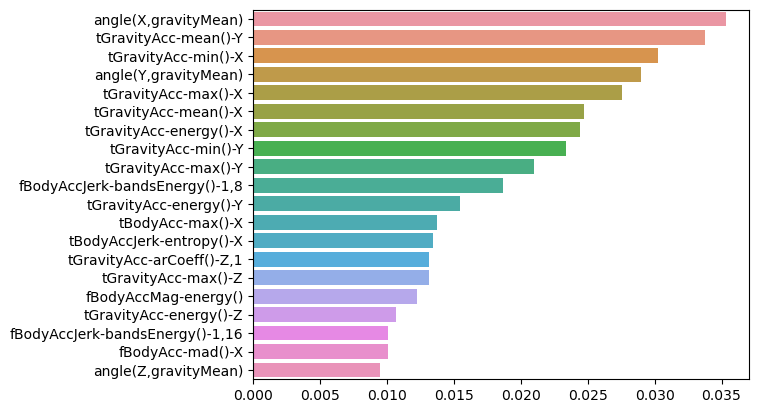

In [59]:
sns.barplot(x=fi.values, y=fi.index)
plt.show()

### GradientBoostingClassifier

In [60]:
from sklearn.ensemble import GradientBoostingClassifier

In [61]:
import time

In [62]:
X_train, X_test, y_train, y_test = get_human_dataset()

In [63]:
start_time = time.time()
gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
pred = gb_clf.predict(X_test)
print(f'정확도: {accuracy_score(y_test, pred)}')
print(f'수행시간: {time.time()-start_time}')

C:\Users\cndud\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


정확도: 0.9389209365456397
수행시간: 495.7537934780121


### XGBoost

In [91]:
from xgboost import XGBClassifier

In [72]:
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, eval_metric='logloss')
xgb_wrapper.fit(X_train, y_train-1, verbose=True)
w_preds = xgb_wrapper.predict(X_test)
accuracy_score(y_test-1, w_preds)

0.9440108585001696

### 조기중단

In [125]:
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, early_stopping_rounds=50, eval_metric='mlogloss')
evals = [(X_test, y_test-1)]
xgb_wrapper.fit(X_train, y_train-1, eval_set=evals, verbose=True)
pred = xgb_wrapper.predict(X_test)
accuracy_score(y_test-1, pred)

[0]	validation_0-mlogloss:1.68862
[1]	validation_0-mlogloss:1.59899
[2]	validation_0-mlogloss:1.51810
[3]	validation_0-mlogloss:1.44654
[4]	validation_0-mlogloss:1.38084
[5]	validation_0-mlogloss:1.31810
[6]	validation_0-mlogloss:1.26067
[7]	validation_0-mlogloss:1.20884
[8]	validation_0-mlogloss:1.16069
[9]	validation_0-mlogloss:1.11570
[10]	validation_0-mlogloss:1.07293
[11]	validation_0-mlogloss:1.03424
[12]	validation_0-mlogloss:0.99679
[13]	validation_0-mlogloss:0.96174
[14]	validation_0-mlogloss:0.92854
[15]	validation_0-mlogloss:0.89723
[16]	validation_0-mlogloss:0.86819
[17]	validation_0-mlogloss:0.84045
[18]	validation_0-mlogloss:0.81269
[19]	validation_0-mlogloss:0.78752
[20]	validation_0-mlogloss:0.76319
[21]	validation_0-mlogloss:0.74086
[22]	validation_0-mlogloss:0.71917
[23]	validation_0-mlogloss:0.69963
[24]	validation_0-mlogloss:0.68019
[25]	validation_0-mlogloss:0.66184
[26]	validation_0-mlogloss:0.64390
[27]	validation_0-mlogloss:0.62823
[28]	validation_0-mlogloss:0.6

[231]	validation_0-mlogloss:0.14671
[232]	validation_0-mlogloss:0.14670
[233]	validation_0-mlogloss:0.14651
[234]	validation_0-mlogloss:0.14633
[235]	validation_0-mlogloss:0.14643
[236]	validation_0-mlogloss:0.14617
[237]	validation_0-mlogloss:0.14604
[238]	validation_0-mlogloss:0.14600
[239]	validation_0-mlogloss:0.14578
[240]	validation_0-mlogloss:0.14561
[241]	validation_0-mlogloss:0.14553
[242]	validation_0-mlogloss:0.14568
[243]	validation_0-mlogloss:0.14561
[244]	validation_0-mlogloss:0.14536
[245]	validation_0-mlogloss:0.14513
[246]	validation_0-mlogloss:0.14486
[247]	validation_0-mlogloss:0.14457
[248]	validation_0-mlogloss:0.14449
[249]	validation_0-mlogloss:0.14411
[250]	validation_0-mlogloss:0.14440
[251]	validation_0-mlogloss:0.14419
[252]	validation_0-mlogloss:0.14423
[253]	validation_0-mlogloss:0.14403
[254]	validation_0-mlogloss:0.14409
[255]	validation_0-mlogloss:0.14400
[256]	validation_0-mlogloss:0.14391
[257]	validation_0-mlogloss:0.14377
[258]	validation_0-mlogloss:

0.9440108585001696

### LightGBM

In [96]:
from lightgbm import LGBMClassifier

In [102]:
import lightgbm

In [103]:
lightgbm.__version__

'4.6.0'

In [128]:
X_train

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.299665,-0.057193,-0.181233,-0.195387,0.039905,0.077078,-0.282301,0.043616,0.060410,0.210795,...,-0.070157,-0.588433,-0.880324,-0.190437,0.829718,0.206972,-0.425619,-0.791883,0.238604,0.049819
7348,0.273853,-0.007749,-0.147468,-0.235309,0.004816,0.059280,-0.322552,-0.029456,0.080585,0.117440,...,0.165259,-0.390738,-0.680744,0.064907,0.875679,-0.879033,0.400219,-0.771840,0.252676,0.050053
7349,0.273387,-0.017011,-0.045022,-0.218218,-0.103822,0.274533,-0.304515,-0.098913,0.332584,0.043999,...,0.195034,0.025145,-0.304029,0.052806,-0.266724,0.864404,0.701169,-0.779133,0.249145,0.040811
7350,0.289654,-0.018843,-0.158281,-0.219139,-0.111412,0.268893,-0.310487,-0.068200,0.319473,0.101702,...,0.013865,0.063907,-0.344314,-0.101360,0.700740,0.936674,-0.589479,-0.785181,0.246432,0.025339


In [129]:
lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, early_stopping_rounds=50, eval_metric='mlogloss')

X_train.columns = [f'feature_{i}' for i in range(X_train.shape[1])]
X_test.columns = X_train.columns

evals = [(X_test, y_test-1)]
lgbm_wrapper.fit(X_train, y_train-1, eval_set=evals)
pred = lgbm_wrapper.predict(X_test)
accuracy_score(y_test-1, pred)

C:\Users\cndud\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cndud\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 140170
[LightGBM] [Info] Number of data points in the train set: 7352, number of used features: 561
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score -1.791216
[LightGBM] [Info] Start training from score -1.924514
[LightGBM] [Info] Start training from score -2.009071
[LightGBM] [Info] Start training from score -1.743436
[LightGBM] [Info] Start training from score -1.677246
[LightGBM] [Inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

0.9463861554122837